# **Titanic - Machine Learning from Disaster - Neural Network**

このノートブックでは、
Kaggleコンペティション「Titanic - Machine Learning from Disaster」のデータセットを使用し、  
ニューラルネットワーク(MLP)を用いた分類モデルの構築を行っています。  

本モデルは、LightGBM・CatBoostといったメインのモデル構築とは別に、  
**補助的な位置づけ(脇役)として試行的に実装したもの**です。

- 前処理済み特徴量を活かしたMLP構築
- 交差検証(Stratified KFold)による安定したスコアリング
- 過学習防止・汎化性能を意識したモデルの工夫
  
機械学習ベースのアプローチに加え、  
**深層学習の手法でどこまでの精度を出せるのか**を確認することを目的としております。  

本ノートブックの役割は"メインスコア更新"ではなく、  
**モデルアプローチの幅を持たせるための検証・補強的な取り組み**となっております。



## モジュールの読み込み

In [154]:
import os
from pathlib import Path
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
# import lightgbm as lgb
# from lightgbm import LGBMClassifier
# from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings('ignore')

## データの読み込み(kaggle.jsonで読み込む)

In [155]:
# # kaggle.jsonのアップロード
# files.upload()

In [156]:
# # kaggle.json用のフォルダ作成
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# # アクセス権限の許可
# !chmod 600 ~/.kaggle/kaggle.json

In [157]:
# Pathの設定
path = Path(".")
data_path = path / "data"
input_path = data_path / "input"
output_path = data_path / "output"

model_state_path = data_path / "model_state"

# フォルダの作成
input_path.mkdir(parents=True, exist_ok=True)
output_path.mkdir(parents=True, exist_ok=True)
model_state_path.mkdir(parents=True, exist_ok=True)

In [158]:
# # データセットのダウンロード
# !kaggle competitions download -c titanic -p {input_path}
# # titanic.zipの解凍
# !unzip {input_path}/titanic.zip -d {input_path}
# # titanic.zipの削除
# !rm {input_path}/titanic.zip

In [159]:
# csvpathの取得
csv_list = sorted(glob(f"{input_path}/*.csv"))

# csvの読み込み
train = pd.read_csv(csv_list[2])
test = pd.read_csv(csv_list[1])
submission = pd.read_csv(csv_list[0])

# 配列の要素数の確認
print(train.shape, test.shape, submission.shape)

(891, 12) (418, 11) (418, 2)


## データの確認

In [160]:
# datasetの作成(欠損値の補完のため)
dataset = pd.concat([train, test], sort=False)
df = dataset.copy()

# dfの確認
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [161]:
# 各カラムのdtypeの確認
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [162]:
# 詳細なデータの確認(numberカラム)
df.describe(include=np.number)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [163]:
# 詳細なデータの確認(objectカラム)
df.describe(exclude=np.number)

,Name,Sex,Ticket,Cabin,Embarked
count,1309,1309,1309,295,1307
unique,1307,2,929,186,3
top,"Kelly, Mr. James",male,CA. 2343,C23 C25 C27,S
freq,2,843,11,6,914


## データの前処理

In [164]:
# 欠損値の確認
df.isnull().sum()

,0
PassengerId,0
Survived,418
Pclass,0
Name,0
Sex,0
Age,263
SibSp,0
Parch,0
Ticket,0
Fare,1


In [165]:
# # Cabinの削除(欠損値が多いため)
# df.drop(columns="Cabin", inplace=True)

# 欠損値の処理
df["Age"] = df["Age"].fillna(df["Age"].median())
df["Fare"] = df["Fare"].fillna(df["Fare"].median())
df["Embarked"] = df["Embarked"].fillna("S")

In [166]:
# 再度、欠損値の確認
df.isnull().sum()

,0
PassengerId,0
Survived,418
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


In [167]:
# 特徴量エンジニアリングの定義
def feature_engineering(df):
    # Cabin より Deck の作成
    df["Deck"] = df["Cabin"].apply(lambda x: str(x)[0])
    df["Deck"] = df["Deck"].fillna("Nan")

    # Ticket より Prefix の作成
    df["Ticket_prefix"] = df["Ticket"].str.extract(r"^([A-Za-z./\s]+)", expand=False).str.strip()
    df["Ticket_prefix"] = df["Ticket_prefix"].fillna("Nan")

    # Sibsp と Parch より Family Size の作成
    df["Family_size"] = df["SibSp"] + df["Parch"] + 1

    # Name より Title の作成
    df["Name_Title"] = df["Name"].str.extract(r",\s*([^\.]*)\s*\.", expand=False).str.strip()

    return df

In [168]:
# 特徴量エンジニアリング
df = feature_engineering(df)

### MLPモデル用の前処理ステップ  
  
ニューラルネットワーク(MLP)に入力するために、以下の前処理を行います。
- **カテゴリ変数(object型)**  
=> 'astype("category")'によるカテゴリ型変換後、**OneHotEncoding**を実施
- **数値変数**  
=> **MinMaxScaler** によって、スケーリング(0～1の範囲に正規化)  

これらにより、MLPモデルに適した形式へと整えています。

In [169]:
# カテゴリ型変換
cat_cols = ["Survived", "Sex", "Embarked", "Deck", "Ticket_prefix", "Name_Title", "Pclass"]
df[cat_cols] = df[cat_cols].astype("category")

In [170]:
# OneHotEncodingの実施
df = pd.get_dummies(df, columns=["Sex", "Embarked", "Deck", "Ticket_prefix", "Name_Title", "Pclass"], dtype=np.int8)

In [171]:
# MinMaxScalerによる正規化
minmax_cols = ["Age", "Fare", "Family_size", "SibSp", "Parch"]
scaler = MinMaxScaler()
df[minmax_cols] = scaler.fit_transform(df[minmax_cols])

In [172]:
# 特徴量の設定
EX_cols = ["Survived", "PassengerId", "Name", "Ticket", "Cabin"]
FEATURES = [col for col in df.columns if col not in EX_cols]

print(f"説明変数: {FEATURES}")

説明変数: ['Age', 'SibSp', 'Parch', 'Fare', 'Family_size', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Deck_n', 'Ticket_prefix_A', 'Ticket_prefix_A.', 'Ticket_prefix_A./', 'Ticket_prefix_A/', 'Ticket_prefix_A/S', 'Ticket_prefix_AQ/', 'Ticket_prefix_C', 'Ticket_prefix_C.A.', 'Ticket_prefix_C.A./SOTON', 'Ticket_prefix_CA', 'Ticket_prefix_CA.', 'Ticket_prefix_F.C.', 'Ticket_prefix_F.C.C.', 'Ticket_prefix_Fa', 'Ticket_prefix_LINE', 'Ticket_prefix_LP', 'Ticket_prefix_Nan', 'Ticket_prefix_P/PP', 'Ticket_prefix_PC', 'Ticket_prefix_PP', 'Ticket_prefix_S.C./A.', 'Ticket_prefix_S.C./PARIS', 'Ticket_prefix_S.O./P.P.', 'Ticket_prefix_S.O.C.', 'Ticket_prefix_S.O.P.', 'Ticket_prefix_S.P.', 'Ticket_prefix_S.W./PP', 'Ticket_prefix_SC', 'Ticket_prefix_SC/A', 'Ticket_prefix_SC/A.', 'Ticket_prefix_SC/AH', 'Ticket_prefix_SC/AH Basle', 'Ticket_prefix_SC/PARIS', 'Ticket_prefix_SC/Paris', 'Ticket_prefix_SCO/W

In [173]:
df[FEATURES].head()

,Age,SibSp,Parch,Fare,Family_size,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,...,Name_Title_Mme,Name_Title_Mr,Name_Title_Mrs,Name_Title_Ms,Name_Title_Rev,Name_Title_Sir,Name_Title_the Countess,Pclass_1,Pclass_2,Pclass_3
0,0.273456,0.125,0.0,0.014151,0.1,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,1
1,0.473882,0.125,0.0,0.139136,0.1,1,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
2,0.323563,0.000,0.0,0.015469,0.0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0.436302,0.125,0.0,0.103644,0.1,1,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
4,0.436302,0.000,0.0,0.015713,0.0,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,1


In [174]:
# dfを train と test に再分割(Survivedがnanではない=>train, Survivedがnanである=>test)
train = df[df["Survived"].notnull()]
test = df[df["Survived"].isnull()]

# 配列の要素数の確認
print(train.shape, test.shape)

(891, 91) (418, 91)


## 学習ループ(NN)

In [175]:
# モデル構築(MLP)
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropput=0.2):
        super().__init__()
        self.layers = nn.ModuleDict({
            "layer1": nn.Sequential(
                nn.Linear(input_dim, hidden_dim*4),
                nn.BatchNorm1d(hidden_dim*4),
                nn.ReLU(),
                nn.Dropout(dropput)
            ),
            "layer2": nn.Sequential(
                nn.Linear(hidden_dim*4, hidden_dim*2),
                nn.BatchNorm1d(hidden_dim*2),
                nn.ReLU(),
                nn.Dropout(dropput)
            ),
            "layer3": nn.Sequential(
                nn.Linear(hidden_dim*2, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU()
            ),
            "layer4": nn.Sequential(
                nn.Linear(hidden_dim, output_dim)
            )
        })

    def forward(self, x):
        for layer in self.layers.values():
            x = layer(x)
        return x

In [176]:
# 学習ループの定義
def train_model(model, train_loader, valid_loader, criterion, optimizer, EPOCH, fold):
    best_valid_auc = 0

    for epoch in range(EPOCH):
        model.train()
        # 変数の初期化
        auc_total = 0
        loss_total = 0

        # ミニバッチによる学習ループ
        for X_train, y_train in train_loader:
            X_train, y_train = X_train.to(device), y_train.to(device)

            # バックプロパゲーションによるweightとbiasの調整
            optimizer.zero_grad()
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train.unsqueeze(1))
            loss.backward()
            optimizer.step()

            # 学習可視化のための前処理
            y_pred = torch.sigmoid(y_pred)
            y_train, y_pred = y_train.cpu().detach().numpy(), y_pred.cpu().detach().numpy()

            # ミニバッチサイズ分で掛けてトータルを導く
            auc_total += roc_auc_score(y_train, y_pred) * X_train.size(0)
            loss_total += loss.item() * X_train.size(0)

        # トータルから総データ数で割って1EPOCHの平均評価を導く
        train_auc = auc_total / len(train_dataset)
        train_loss = loss_total / len(train_dataset)

        # 50エポックごとに評価の表示
        if (epoch+1) % 50 == 0:
            print(f"Train [EPOCH: {epoch+1}/{EPOCH}], Train Loss: {train_loss:.4f}, Train AUC: {train_auc:.4f}")

        # 勾配計算をできないよう設定
        model.eval()
        with torch.no_grad():
            # 変数の初期化
            acc_total = 0
            auc_total = 0
            loss_total = 0

            # ミニバッチによる評価ループ
            for X_valid, y_valid in valid_loader:
                X_valid, y_valid = X_valid.to(device), y_valid.to(device)

                # 予測の出力とlossの出力
                y_pred = model(X_valid)
                loss = criterion(y_pred, y_valid.unsqueeze(1))

                # ROC AUC Score
                ## 学習可視化のための前処理
                y_pred = torch.sigmoid(y_pred)
                y_valid, y_pred = y_valid.cpu().detach().numpy(), y_pred.cpu().detach().numpy()
                auc_total += roc_auc_score(y_valid, y_pred) * X_valid.size(0)

                # Accuracy Score
                ## 学習可視化のための前処理
                y_pred = np.where(y_pred > 0.5, 1, 0)
                acc_total += accuracy_score(y_valid, y_pred) * X_valid.size(0)
                loss_total += loss.item() * X_valid.size(0)

            # トータルから総データ数で割って1EPOCHの平均評価を導く
            valid_acc = acc_total / len(valid_dataset)
            valid_auc = auc_total / len(valid_dataset)
            valid_loss = loss_total / len(valid_dataset)

            # valid_aucがbest_valid_aucを超えた場合、モデルのステータス保存
            if valid_auc > best_valid_auc:
                best_valid_auc = valid_auc
                best_model_path = model_state_path / f"best_model_{fold}.pth"
                torch.save(model.state_dict(), best_model_path)

            # 50エポックごとに評価の表示
            if (epoch+1) % 50 == 0:
                print(f"Valid [EPOCH: {epoch+1}/{EPOCH}], Valid Loss: {valid_loss:.4f}, Valid AUC: {valid_auc:.4f}, Valid ACC: {valid_acc:.4f}")
                print()

    # Best Valid AUCの表示
    print(f"[FOLD {fold}] Best Valid AUC: {best_valid_auc:.4f}")
    print()

In [177]:
# デバイスの設定(GPUがある場合はCUDA、ない場合はCPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [178]:
# ハイパーパラメータの設定
lr = 0.003
FOLDS = 5
batch_size = 32
EPOCH = 300
seed=42

# モデルのパラメータ設定
input_dim = len(FEATURES)
hidden_dim = 128
output_dim = 1

# 交差検証の設定
cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)

In [179]:
!pip install torchinfo
from torchinfo import summary

# summaryによるモデルの可視化
model = MLP(input_dim, hidden_dim, output_dim).to(device)
summary(model, input_size=(1, input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [1, 1]                    --
├─ModuleDict: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 512]                  --
│    │    └─Linear: 3-1                  [1, 512]                  44,544
│    │    └─BatchNorm1d: 3-2             [1, 512]                  1,024
│    │    └─ReLU: 3-3                    [1, 512]                  --
│    │    └─Dropout: 3-4                 [1, 512]                  --
│    └─Sequential: 2-2                   [1, 256]                  --
│    │    └─Linear: 3-5                  [1, 256]                  131,328
│    │    └─BatchNorm1d: 3-6             [1, 256]                  512
│    │    └─ReLU: 3-7                    [1, 256]                  --
│    │    └─Dropout: 3-8                 [1, 256]                  --
│    └─Sequential: 2-3                   [1, 128]                  --
│ 

In [180]:
# criterion, optimizerの設定
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [181]:
# 交差検証
for fold, (train_idx, valid_idx) in enumerate(cv.split(train[FEATURES], train["Survived"]), 1):
    print("#"*40)
    print(f"### [FOLD {fold}/{FOLDS}]")
    print(f"### train_idx: {len(train_idx)}, valid_idx: {len(valid_idx)}")
    print("#"*40)

    # データの分割
    X_train = train.loc[train_idx, FEATURES]
    y_train = train.loc[train_idx, "Survived"]
    X_valid = train.loc[valid_idx, FEATURES]
    y_valid = train.loc[valid_idx, "Survived"]

    # Tensor型への変換
    X_train = torch.tensor(X_train.values, dtype=torch.float32)
    y_train = torch.tensor(y_train.values, dtype=torch.float32)
    X_valid = torch.tensor(X_valid.values, dtype=torch.float32)
    y_valid = torch.tensor(y_valid.values, dtype=torch.float32)

    # TensorDatasetの作成
    train_dataset = TensorDataset(X_train, y_train)
    valid_dataset = TensorDataset(X_valid, y_valid)

    # DataLoaderの作成
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    # モデルの学習とステータス保存
    train_model(model, train_loader, valid_loader, criterion, optimizer, EPOCH, fold)

########################################
### [FOLD 1/5]
### train_idx: 712, valid_idx: 179
########################################
Train [EPOCH: 50/300], Train Loss: 0.3206, Train AUC: 0.9368
Valid [EPOCH: 50/300], Valid Loss: 0.4116, Valid AUC: 0.8878, Valid ACC: 0.8492

Train [EPOCH: 100/300], Train Loss: 0.2824, Train AUC: 0.9458
Valid [EPOCH: 100/300], Valid Loss: 0.4236, Valid AUC: 0.8902, Valid ACC: 0.8547

Train [EPOCH: 150/300], Train Loss: 0.2519, Train AUC: 0.9530
Valid [EPOCH: 150/300], Valid Loss: 0.5323, Valid AUC: 0.8805, Valid ACC: 0.8324

Train [EPOCH: 200/300], Train Loss: 0.2472, Train AUC: 0.9601
Valid [EPOCH: 200/300], Valid Loss: 0.4759, Valid AUC: 0.8756, Valid ACC: 0.8380

Train [EPOCH: 250/300], Train Loss: 0.2447, Train AUC: 0.9561
Valid [EPOCH: 250/300], Valid Loss: 0.5582, Valid AUC: 0.8727, Valid ACC: 0.8492

Train [EPOCH: 300/300], Train Loss: 0.2316, Train AUC: 0.9632
Valid [EPOCH: 300/300], Valid Loss: 0.6648, Valid AUC: 0.8646, Valid ACC: 0.8324

[FOLD 

## 提出ファイルの作成

In [182]:
# 各ステータスを読み込んで、予測を出力する
def models_predict(X, model, model_state_path):

    # モデルのステータスファイルをリストで取得
    models_state = glob(f"{model_state_path}/*.pth")
    preds = []

    # 各ステータスの読み込み
    for model_state in models_state:
        model.load_state_dict(torch.load(model_state))

        # 勾配計算をできないよう設定
        model.eval()
        with torch.no_grad():

            # 予測の出力
            y_pred = model(X)
            y_pred = torch.sigmoid(y_pred)
            y_pred = y_pred.cpu().detach().numpy()

            # predsへ追加
            preds.append(y_pred)

    # predsのndarray変換
    preds_array = np.array(preds)

    # 平均を出して 1, 0 に変換する
    pred = np.mean(preds_array, axis=0)
    pred = np.where(pred > 0.5, 1, 0)

    # 配列の要素の数を整える
    pred = pred.reshape(-1)

    return pred


In [183]:
# Tensor型への変換
X_test = torch.tensor(test[FEATURES].values, dtype=torch.float32).to(device)

# 予測の出力
y_pred = models_predict(X_test, model, model_state_path)

# 提出ファイルのデータ作成
submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": y_pred
})

In [184]:
# 提出ファイルの作成
submission.to_csv(output_path / "submission_nn.csv", index=False)

提出スコア: **0.76076**

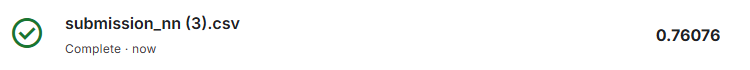

## まとめ

本ノートブックでは、Titanicコンペを題材に、MLP(多層パーセプトロン)による分類モデルの構築を行いました。  
  
メインモデル・ベースラインモデルで得た知見を活かしつつ、  
ニューラルネットワークの可能性を改めて確認できた、実験的でありながら手ごたえのある取り組みになりました。  
  
- pytorchを利用した分類モデル(MLP)の構築
- ニューラルネットの交差検証の実装と評価
- 汎化性能を高めるための各種工夫
  
深層学習への理解を再確認し、Titanicの課題に新たな角度で挑戦できたことは、  
今後のモデリングにつながる、貴重な経験となりました。  
  
---
  
最後までご覧いただき、誠にありがとうございました。  
本ノートブックが、私の学習・成長の過程を知っていたく一助となれば幸いです。